In [ ]:
import pandas as pd

import nltk
from nltk.corpus import stopwords
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

import seaborn as sns
from sklearn.metrics import confusion_matrix

import spacy

In [2]:
posts_path = '4chan/output/posts.csv'
threads_path = '4chan/output/threads.csv'

chan4_posts = pd.read_csv(posts_path)
chan4_threads = pd.read_csv(threads_path)

posts_end_path  = 'endchan V2/output/posts.csv'
threads_end_path = 'endchan V2/output/threads.csv'

endchan_posts = pd.read_csv(posts_end_path)
endchan_threads = pd.read_csv(threads_end_path)

In [3]:
chan4_posts.head(5)
# 40459 x 4

,subpost_id,content,time,thread_id
0,p501099183,>>501098958 (OP)I used an anal egg to make me ...,03/21/25(Fri)13:43:02No.501099183,p501098958
1,p501099437,corporate farming was a mistakepicrel is the c...,03/21/25(Fri)13:46:36No.501099437,p501098958
2,p501100092,>>501098958 (OP)Almost like the old administra...,03/21/25(Fri)13:55:59No.501100092,p501098958
3,p501100224,">>501100092Trump started the fake pandemic, st...",03/21/25(Fri)13:57:44No.501100224,p501098958
4,p501101758,>>501098958 (OP)>what did americans mean by th...,03/21/25(Fri)14:17:04No.501101758,p501098958


In [4]:
chan4_threads.head(5)
# 470 x 6

,thread_id,thread_text,time
0,p501098958,>kill all of our domestic chickens because fak...,03/21/25(Fri)13:40:04No.501098958
1,p501104660,Denmark is the best country in Europe and I'm ...,03/21/25(Fri)14:53:50No.501104660
2,p501098958,>kill all of our domestic chickens because fak...,03/21/25(Fri)13:40:04No.501098958
3,p501101640,NaN,03/21/25(Fri)14:15:39No.501101640
4,p501099426,You can't be racist and pagan.You can't be pro...,03/21/25(Fri)13:46:30No.501099426


Already noticing the time is off, so will have to clean this up

In [5]:
endchan_posts.head(5)
# 6014 x 4

,subpost_id,content,time,thread_id
0,91434,>>91417>killed off most of the savage Natives ...,10/28/2023 (Sat) 08:22,91417
1,91435,Netanyahu's not a white boy. Nor is any Yidd. ...,10/28/2023 (Sat) 11:34,91417
2,91448,NaN,10/29/2023 (Sun) 14:19,91417
3,92023,Idk but it makes me want to pull my hair out. ...,12/26/2023 (Tue) 02:46,91417
4,92024,>>92023,12/26/2023 (Tue) 07:50,91417


In [6]:
endchan_threads.head(5)
# 135 x 3

,thread_id,thread_text,time
0,91417,"What's wrong with all of you poor, pathetic, s...",10/27/2023 (Fri) 15:50
1,95327,1) disable or heavily damage the kike propagan...,12/08/2024 (Sun) 23:36
2,93932,They like to call Jerry Seinfeld a “funnyman” ...,06/15/2024 (Sat) 11:36
3,90261,The Natashas 2003.https://www.scribd.com/docum...,04/14/2023 (Fri) 02:05
4,94806,Hello from soyjak.party.gemmy board,09/28/2024 (Sat) 02:57


# Topic modeling with 4chan data

Thread is the main post, posts is the comments underneath one thread <br>
Topics across one thread should be the same, as the thread decides the topic. Therefore, it is most logical to use threads to do topic modeling.

In [7]:
# Cleaning the time column of chan4_threads
chan4_threads['time'] = chan4_threads['time'].str.split('No.').str[0]

## Basic topic modeling with regular libraries

### NLTK and Scikit-Learn

In [8]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

In [9]:
# cleaning master function
def clean_thread(thread, bigrams=False):
    if not isinstance(thread, str):  # Handle non-string values
        thread = ''
    thread = thread.lower()  # lower case
    thread = re.sub('[' + my_punctuation + ']+', ' ', thread)  # strip punctuation
    # thread = re.sub('\s+', ' ', thread)  # remove double spacing
    thread = re.sub('([0-9]+)', '', thread)  # remove numbers
    thread_token_list = [word for word in thread.split(' ')
                         if word not in my_stopwords]  # remove stopwords

    # thread_token_list = [word_rooter(word) if '#' not in word else word
    #                      for word in thread_token_list]  # apply word rooter
    if bigrams:
        thread_token_list = thread_token_list + [thread_token_list[i] + '_' + thread_token_list[i + 1]
                                                 for i in range(len(thread_token_list) - 1)]
    thread = ' '.join(thread_token_list)
    return thread


chan4_threads['cleaned'] = chan4_threads['thread_text'].apply(clean_thread)
chan4_threads['cleaned']

0       kill domestic chickens fake pcr test said egg...
1          denmark best country europe tired pretending 
2       kill domestic chickens fake pcr test said egg...
3                                                       
4      racist pagan pro white pagan pro christian pag...
                             ...                        
465     white east asian interbreeding le bad princip...
466    docsits relevantisraeli nuclear program spotte...
467    young white men across world turning fascism n...
468    libs slated get majority  accelerationism answ...
469     baltics   whitebaltics   white baltics   whit...
Name: cleaned, Length: 470, dtype: object

In [10]:
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=25, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf = vectorizer.fit_transform(chan4_threads['cleaned']).toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names_out()

In [11]:
number_of_topics = 5
model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
model.fit(tf)

LatentDirichletAllocation(n_components=5, random_state=0)

In [12]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [13]:
no_top_words = 15
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,https,128.2,us,42.1,make,70.4,even,39.5,white,78.5
1,trump,120.0,go,35.0,like,45.9,www,36.0,would,61.3
2,com,101.2,europe,30.2,get,23.1,uk,33.2,people,36.1
3,www,55.4,’s,26.4,year,18.4,new,26.2,world,29.7
4,year,14.0,like,18.5,would,7.3,’s,19.8,literally,27.2
5,every,10.4,uk,7.3,people,6.7,full,18.5,government,14.7
6,uk,9.1,world,5.7,white,0.9,go,15.4,even,9.9
7,make,5.3,www,0.2,even,0.2,people,12.9,every,9.5
8,full,4.9,year,0.2,go,0.2,make,11.9,get,8.3
9,government,4.8,would,0.2,government,0.2,government,8.1,full,4.2


### BERTopic

In [14]:
from bertopic import BERTopic

d:\OneDrive - TU Eindhoven\JADS\Semester B\Data Forensics\Project\Data-Forensics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
topic_model = BERTopic()
docs = chan4_threads['cleaned'].tolist()
topics, probs = topic_model.fit_transform(docs)
chan4_threads['topics'] = topics
chan4_threads['topic_probs'] = probs

In [16]:
BERTopics = topic_model.get_topic_info()
BERTopics

,Topic,Count,Name,Representation,Representative_Docs
0,-1,17,-1_india_china_manufacturing_chinese,"[india, china, manufacturing, chinese, factori...",[india failed attract factories china went wr...
1,0,46,0_make_would_recall_woods,"[make, would, recall, woods, european, japanes...",[morons using wrong glue tesla forced recall e...
2,1,37,1_white_search_google_anti,"[white, search, google, anti, nobody, men, fam...",[objectively nasty world class rbf tds nut f...
3,2,34,2_step_government_us_great,"[step, government, us, great, america, every, ...",[antifa violence endless new waves vandalism ...
4,3,30,3_go_coffee_woke_br,"[go, coffee, woke, br, britbros, courts, cup, ...",[sorry britbros coffee much delicious tea th...
5,4,29,4_white_baltics_tomatokikes_shitalians,"[white, baltics, tomatokikes, shitalians, conv...",[convinced majority shitalians white they’re ...
6,5,25,5_notice_something_drop_mic,"[notice, something, drop, mic, , , , , , ]","[notice something, notice something, notice so..."
7,6,25,6_ukraine_bbc_uk_catbox,"[ukraine, bbc, uk, catbox, moe, news, co, arti...",[previous →day — daily battlefield assessme...
8,7,22,7_poilievre_polls_policy_real,"[poilievre, polls, policy, real, never, pol, c...",[poilievre afraid policy conservatives policy...
9,8,21,8_prison_lockdown_inmates_staff,"[prison, lockdown, inmates, staff, thomson, gu...",[whoever cares hear massive defrauding taxpay...


In [17]:
topic_model.visualize_topics()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'customdata': array([[0, 'make | would | recall | woods | european', 46],
                                   [1, 'white | search | google | anti | nobody', 37],
                                   [2, 'step | government | us | great | america', 34],
                                   [3, 'go | coffee | woke | br | britbros', 30],
                                   [4, 'white | baltics | tomatokikes | shitalians | convinced', 29],
                                   [5, 'notice | something | drop | mic | ', 25],
                                   [6, 'ukraine | bbc | uk | catbox | moe', 25],
                                   [7, 'poilievre | polls | policy | real | never', 22],
                                   [8, 'prison | lockdown | inmates | staff | thomson', 21],
                                   [9, 'chickens | eggs | test | genocide | pro', 18],
                                   [10, 'netanyahu | palestine | jfk | relevantisraeli | research', 18],
                                   [11, 'care | fuck | russians | careare | allies', 18],
                                   [12, 'christianity | us | migration | would | led', 18],
                                   [13, 'want | child | baby | kids | sugar', 18],
                                   [14, 'niggers | dei | jobs | use | hate', 17],
                                   [15, 'trump | https | com | washington | dc', 15],
                                   [16, 'pagan | post | nazi | memes | pro', 15],
                                   [17, 'english | dropped | recognize | official | wqygcbceceu', 13],
                                   [18, 'consciousness | soul | its | like | dwelled', 12],
                                   [19, 'faces | sold | even | makes | anymore', 11],
                                   [20, 'east | white | bunnies | snow | interbreeding', 11]], dtype=object),
              'hovertemplate': '<b>Topic %{customdata[0]}</b><br>%{customdata[1]}<br>Size: %{customdata[2]}',
              'legendgroup': '',
              'marker': {'color': '#B0BEC5',
                         'line': {'color': 'DarkSlateGrey', 'width': 2},
                         'size': {'bdata': 'LiUiHh0ZGRYVEhISEhIRDw8NDAsL', 'dtype': 'i1'},
                         'sizemode': 'area',
                         'sizeref': 0.02875,
                         'symbol': 'circle'},
              'mode': 'markers',
              'name': '',
              'orientation': 'v',
              'showlegend': False,
              'type': 'scatter',
              'x': {'bdata': ('NTdKQSIhQEEydItB3kwwQZVpNkFPCT' ... 'eKQTUaVUGceYdBxvgqQYfYOEFLCztB'),
                    'dtype': 'f4'},
              'xaxis': 'x',
              'y': {'bdata': ('+88qv+SUiz+0sOJAPQVkv6fN7j/BoJ' ... '7YQJVAyL/6o95A04SMv4B6eD/DScU/'),
                    'dtype': 'f4'},
              'yaxis': 'y'}],
    'layout': {'annotations': [{'showarrow': False,
                                'text': 'D1',
                                'x': np.float32(-4.3326325),
                                'y': np.float32(3.3312314),
                                'yshift': 10},
                               {'showarrow': False,
                                'text': 'D2',
                                'x': np.float32(8.186059),
                                'xshift': 10,
                                'y': np.float32(8.461604)}],
               'height': 650,
               'hoverlabel': {'bgcolor': 'white', 'font': {'family': 'Rockwell', 'size': 16}},
               'legend': {'itemsizing': 'constant', 'tracegroupgap': 0},
               'margin': {'t': 60},
               'shapes': [{'line': {'color': '#CFD8DC', 'width': 2},
                           'type': 'line',
                           'x0': np.float32(8.186059),
                           'x1': np.float32(8.186059),
                           'y0': np.float32(-1.7991415),
                           'y1': np.float32(8.461604)},
                   

## DarkBERT

In [18]:
from transformers import pipeline

In [19]:
with open('access_token.txt', 'r') as file:
    access_token = file.read().strip()

In [20]:
unmasker = pipeline('fill-mask', model="s2w-ai/DarkBERT", token=access_token)
unmasker("RagnarLocker, LockBit, and REvil are types of <mask>.")

Device set to use cpu


[{'score': 0.49523264169692993,
  'token': 25346,
  'token_str': ' ransomware',
  'sequence': 'RagnarLocker, LockBit, and REvil are types of ransomware.'},
 {'score': 0.04661604389548302,
  'token': 16886,
  'token_str': ' malware',
  'sequence': 'RagnarLocker, LockBit, and REvil are types of malware.'},
 {'score': 0.042176585644483566,
  'token': 28811,
  'token_str': ' wallets',
  'sequence': 'RagnarLocker, LockBit, and REvil are types of wallets.'},
 {'score': 0.02898237481713295,
  'token': 2196,
  'token_str': ' drugs',
  'sequence': 'RagnarLocker, LockBit, and REvil are types of drugs.'},
 {'score': 0.020001336932182312,
  'token': 11344,
  'token_str': ' hackers',
  'sequence': 'RagnarLocker, LockBit, and REvil are types of hackers.'}]

In [21]:
# Iterate through the 'Representation' column in BERTopics DataFrame
for representation in BERTopics['Representation']:
    # Take only the first 3 words from the representation list
    words = ', '.join(representation[:6])
    # Create the input sentence for the unmasker
    sentence = f"{words} are all types of <mask>"
    # Use the unmasker to predict the masked word
    result = unmasker(sentence)
    print(f"Input: {sentence}")
    print(f"Prediction: {result}\n")

Input: india, china, manufacturing, chinese, factories, threat are all types of <mask>
Prediction: [{'score': 0.21873830258846283, 'token': 3455, 'token_str': ' threats', 'sequence': 'india, china, manufacturing, chinese, factories, threat are all types of threats'}, {'score': 0.17531301081180573, 'token': 1856, 'token_str': ' threat', 'sequence': 'india, china, manufacturing, chinese, factories, threat are all types of threat'}, {'score': 0.02046685852110386, 'token': 4854, 'token_str': ' danger', 'sequence': 'india, china, manufacturing, chinese, factories, threat are all types of danger'}, {'score': 0.019146598875522614, 'token': 383, 'token_str': ' things', 'sequence': 'india, china, manufacturing, chinese, factories, threat are all types of things'}, {'score': 0.0177216287702322, 'token': 4, 'token_str': '.', 'sequence': 'india, china, manufacturing, chinese, factories, threat are all types of.'}]

Input: make, would, recall, woods, european, japanese are all types of <mask>
Predi

# Sentiment Analysis

## Vader

In [26]:
# Download the vader_lexicon resource
nltk.download('vader_lexicon')

# Initialize NLTK sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create get_sentiment function
def get_sentiment(text):
    if not isinstance(text, str):  # Handle non-string values
        text = ''
    scores = analyzer.polarity_scores(text)
    sentiment = 1 if scores['pos'] > 0 else 0
    return sentiment

# Apply get_sentiment function
chan4_posts['sentiment'] = chan4_posts['content'].apply(get_sentiment)
chan4_posts.head(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\20193244\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,subpost_id,content,time,thread_id,sentiment
0,p501099183,>>501098958 (OP)I used an anal egg to make me ...,03/21/25(Fri)13:43:02No.501099183,p501098958,0
1,p501099437,corporate farming was a mistakepicrel is the c...,03/21/25(Fri)13:46:36No.501099437,p501098958,0
2,p501100092,>>501098958 (OP)Almost like the old administra...,03/21/25(Fri)13:55:59No.501100092,p501098958,1
3,p501100224,">>501100092Trump started the fake pandemic, st...",03/21/25(Fri)13:57:44No.501100224,p501098958,0
4,p501101758,>>501098958 (OP)>what did americans mean by th...,03/21/25(Fri)14:17:04No.501101758,p501098958,0


### BERTweet

In [27]:
import torch
from transformers import AutoModel, AutoTokenizer 

In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-large")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-large")

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/bertweet-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
# Tokenize the content column of chan4_posts
chan4_posts['tokenized'] = chan4_posts['content'].dropna().apply(lambda x: tokenizer.encode(x, return_tensors='pt', truncation=True, max_length=512))

# Define a function to extract features using BERTweet
def extract_features(tokenized_text):
    with torch.no_grad():
        features = bertweet(tokenized_text)
    return features.last_hidden_state.mean(dim=1).squeeze().numpy()

This following cell takes 10 hours to run

In [30]:
# Apply the feature extraction function to the tokenized content
chan4_posts['bertweet_features'] = chan4_posts['tokenized'].apply(lambda x: extract_features(x) if isinstance(x, torch.Tensor) else None)

In [31]:
# Display the updated DataFrame
chan4_posts.head()

,subpost_id,content,time,thread_id,sentiment,tokenized,bertweet_features
0,p501099183,>>501098958 (OP)I used an anal egg to make me ...,03/21/25(Fri)13:43:02No.501099183,p501098958,0,"[[tensor(0), tensor(44226), tensor(36144), ten...","[0.06799206, 0.056070276, -0.55798876, 0.04418..."
1,p501099437,corporate farming was a mistakepicrel is the c...,03/21/25(Fri)13:46:36No.501099437,p501098958,0,"[[tensor(0), tensor(7215), tensor(34044), tens...","[-0.0776314, 0.035479527, -0.5825086, 0.027688..."
2,p501100092,>>501098958 (OP)Almost like the old administra...,03/21/25(Fri)13:55:59No.501100092,p501098958,1,"[[tensor(0), tensor(44226), tensor(36144), ten...","[-0.10017324, 0.11870812, -0.3728514, -0.14380..."
3,p501100224,">>501100092Trump started the fake pandemic, st...",03/21/25(Fri)13:57:44No.501100224,p501098958,0,"[[tensor(0), tensor(44226), tensor(36144), ten...","[-0.030243885, -0.043455537, -0.15542412, -0.2..."
4,p501101758,>>501098958 (OP)>what did americans mean by th...,03/21/25(Fri)14:17:04No.501101758,p501098958,0,"[[tensor(0), tensor(44226), tensor(36144), ten...","[-0.1456901, 0.11850904, -0.31451586, -0.13101..."


In [ ]:
# Ensure bertweet_features and sentiment are aligned and drop rows with NaN in either column
valid_rows = chan4_posts.dropna(subset=['bertweet_features', 'sentiment'])

# Extract features and labels
X = np.array(valid_rows['bertweet_features'].tolist())  # Feature vectors
y = valid_rows['sentiment']  # Sentiment labels (e.g., 0 for negative, 1 for positive)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier (or any other model)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict sentiment on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Predict sentiment for new data
# Ensure all feature vectors are valid and have the same length
valid_features = chan4_posts['bertweet_features'].dropna().apply(lambda x: x if isinstance(x, np.ndarray) and x.ndim == 1 else None)
valid_features = valid_features.dropna()

# Predict sentiment for new data
chan4_posts.loc[valid_features.index, 'predicted_sentiment'] = clf.predict(np.array(valid_features.tolist()))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4250
           1       0.99      0.99      0.99      3713

    accuracy                           0.99      7963
   macro avg       0.99      0.99      0.99      7963
weighted avg       0.99      0.99      0.99      7963



In [37]:
# Compare Vader sentiment with BERTweet sentiment
comparison = chan4_posts[['sentiment', 'predicted_sentiment']]
comparison['match'] = comparison['sentiment'] == comparison['predicted_sentiment']

# Calculate the percentage of matching results
match_percentage = comparison['match'].mean() * 100
print(f"Percentage of matching results: {match_percentage:.2f}%")

Percentage of matching results: 98.21%


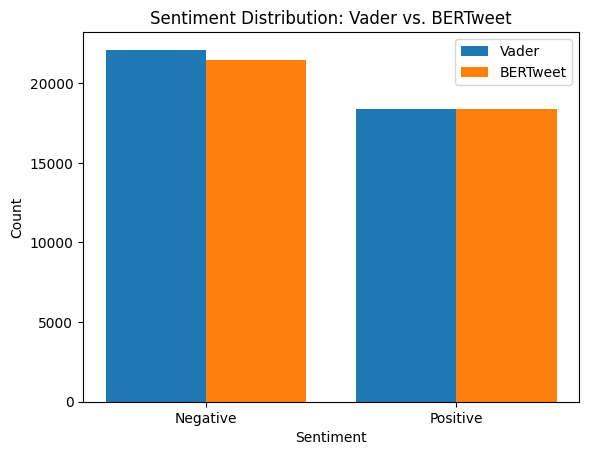

In [40]:
import matplotlib.pyplot as plt

# Count sentiment values for Vader and BERTweet
vader_counts = chan4_posts['sentiment'].value_counts()
bertweet_counts = chan4_posts['predicted_sentiment'].value_counts()

# Create a bar chart
labels = ['Negative', 'Positive']
x = range(len(labels))

plt.bar(x, vader_counts.sort_index(), width=0.4, label='Vader', align='center')
plt.bar([i + 0.4 for i in x], bertweet_counts.sort_index(), width=0.4, label='BERTweet', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution: Vader vs. BERTweet')
plt.legend()
plt.show()

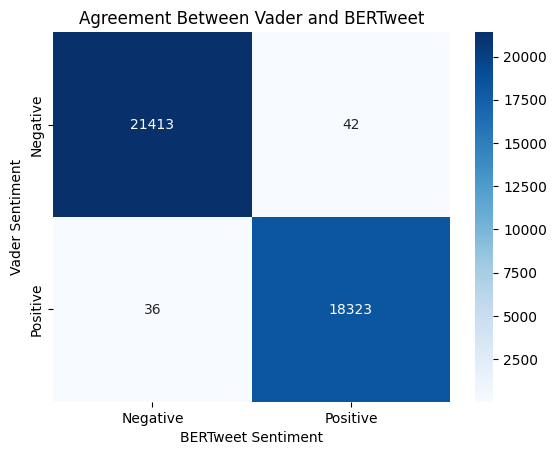

In [45]:
# Filter out rows with NaN values in 'sentiment' or 'predicted_sentiment'
valid_rows = chan4_posts.dropna(subset=['sentiment', 'predicted_sentiment'])

# Create a confusion matrix
conf_matrix = confusion_matrix(valid_rows['sentiment'], valid_rows['predicted_sentiment'])

# Plot the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('BERTweet Sentiment')
plt.ylabel('Vader Sentiment')
plt.title('Agreement Between Vader and BERTweet')
plt.show()

## EndChan

In [47]:
# Apply get_sentiment function
endchan_posts['sentiment'] = endchan_posts['content'].apply(get_sentiment)
endchan_posts.head(5)

,subpost_id,content,time,thread_id,sentiment
0,91434,>>91417>killed off most of the savage Natives ...,10/28/2023 (Sat) 08:22,91417,0
1,91435,Netanyahu's not a white boy. Nor is any Yidd. ...,10/28/2023 (Sat) 11:34,91417,1
2,91448,NaN,10/29/2023 (Sun) 14:19,91417,0
3,92023,Idk but it makes me want to pull my hair out. ...,12/26/2023 (Tue) 02:46,91417,1
4,92024,>>92023,12/26/2023 (Tue) 07:50,91417,0


In [48]:
endchan_posts['tokenized'] = endchan_posts['content'].dropna().apply(lambda x: tokenizer.encode(x, return_tensors='pt', truncation=True, max_length=512))

This following cell takes 42 minutes to run.

In [50]:
endchan_posts['bertweet_features'] = endchan_posts['tokenized'].apply(lambda x: extract_features(x) if isinstance(x, torch.Tensor) else None)

In [51]:
# Display the updated DataFrame
endchan_posts.head()

,subpost_id,content,time,thread_id,sentiment,tokenized,bertweet_features
0,91434,>>91417>killed off most of the savage Natives ...,10/28/2023 (Sat) 08:22,91417,0,"[[tensor(0), tensor(44226), tensor(466), tenso...","[-0.07602725, 0.14235811, -0.39104676, 0.00459..."
1,91435,Netanyahu's not a white boy. Nor is any Yidd. ...,10/28/2023 (Sat) 11:34,91417,1,"[[tensor(0), tensor(15721), tensor(46526), ten...","[-0.086535595, 0.14426668, -0.37721604, -0.021..."
2,91448,NaN,10/29/2023 (Sun) 14:19,91417,0,NaN,None
3,92023,Idk but it makes me want to pull my hair out. ...,12/26/2023 (Tue) 02:46,91417,1,"[[tensor(0), tensor(28081), tensor(330), tenso...","[-0.086770065, 0.124217115, -0.43025732, -0.05..."
4,92024,>>92023,12/26/2023 (Tue) 07:50,91417,0,"[[tensor(0), tensor(44226), tensor(29099), ten...","[-0.11015359, -0.42664695, -0.48898965, -0.200..."


In [52]:
# Ensure bertweet_features and sentiment are aligned and drop rows with NaN in either column
valid_rows = endchan_posts.dropna(subset=['bertweet_features', 'sentiment'])

# Extract features and labels
X = np.array(valid_rows['bertweet_features'].tolist())  # Feature vectors
y = valid_rows['sentiment']  # Sentiment labels (e.g., 0 for negative, 1 for positive)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier (or any other model)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict sentiment on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Predict sentiment for new data
# Ensure all feature vectors are valid and have the same length
valid_features = endchan_posts['bertweet_features'].dropna().apply(lambda x: x if isinstance(x, np.ndarray) and x.ndim == 1 else None)
valid_features = valid_features.dropna()

# Predict sentiment for new data
endchan_posts.loc[valid_features.index, 'predicted_sentiment'] = clf.predict(np.array(valid_features.tolist()))

              precision    recall  f1-score   support

           0       0.71      0.57      0.63       315
           1       0.84      0.91      0.87       800

    accuracy                           0.81      1115
   macro avg       0.78      0.74      0.75      1115
weighted avg       0.81      0.81      0.81      1115



In [53]:
# Compare Vader sentiment with BERTweet sentiment
comparison = endchan_posts[['sentiment', 'predicted_sentiment']]
comparison['match'] = comparison['sentiment'] == comparison['predicted_sentiment']

# Calculate the percentage of matching results
match_percentage = comparison['match'].mean() * 100
print(f"Percentage of matching results: {match_percentage:.2f}%")

Percentage of matching results: 89.18%


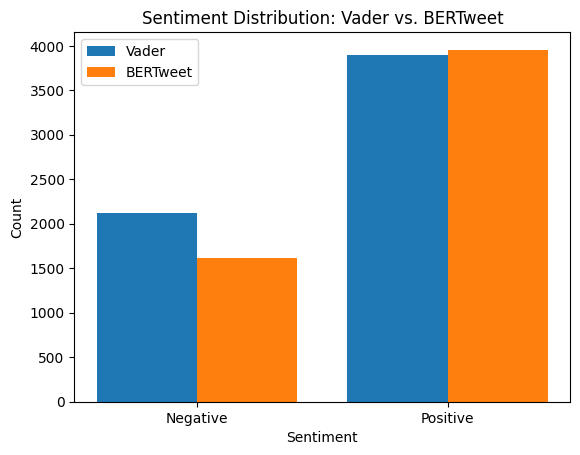

In [54]:
# Count sentiment values for Vader and BERTweet
vader_counts = endchan_posts['sentiment'].value_counts()
bertweet_counts = endchan_posts['predicted_sentiment'].value_counts()

# Create a bar chart
labels = ['Negative', 'Positive']
x = range(len(labels))

plt.bar(x, vader_counts.sort_index(), width=0.4, label='Vader', align='center')
plt.bar([i + 0.4 for i in x], bertweet_counts.sort_index(), width=0.4, label='BERTweet', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution: Vader vs. BERTweet')
plt.legend()
plt.show()

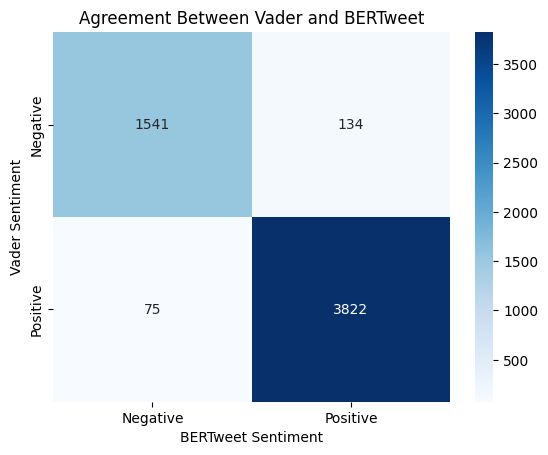

In [55]:
# Filter out rows with NaN values in 'sentiment' or 'predicted_sentiment'
valid_rows = endchan_posts.dropna(subset=['sentiment', 'predicted_sentiment'])

# Create a confusion matrix
conf_matrix = confusion_matrix(valid_rows['sentiment'], valid_rows['predicted_sentiment'])

# Plot the heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('BERTweet Sentiment')
plt.ylabel('Vader Sentiment')
plt.title('Agreement Between Vader and BERTweet')
plt.show()

# Sentiment Analysis With NER

## EndChan

In [62]:
# Install and load spaCy's pre-trained NER model
nlp = spacy.load("en_core_web_sm")

# Function to extract entities
def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Example usage
endchan_posts['entities'] = endchan_posts['content'].apply(lambda x: extract_entities(x) if isinstance(x, str) else None)
endchan_posts[['content', 'entities']].head()

,content,entities
0,>>91417>killed off most of the savage Natives ...,"[(America.*beat, GPE), (British, NORP), (Japan..."
1,Netanyahu's not a white boy. Nor is any Yidd. ...,"[(Netanyahu, PERSON), (British, NORP), (Japane..."
2,NaN,None
3,Idk but it makes me want to pull my hair out. ...,"[(Idk, PERSON), (six, CARDINAL), (million, CAR..."
4,>>92023,"[(92023, CARDINAL)]"


In [63]:
# Function to get sentiment for each entity
def entity_sentiment(text):
    doc = nlp(text)
    entity_sentiments = {}
    for ent in doc.ents:
        # Extract the surrounding context for the entity
        context = text[max(0, ent.start_char - 50):ent.end_char + 50]
        # Get sentiment for the context
        sentiment_score = analyzer.polarity_scores(context)['compound']
        entity_sentiments[ent.text] = sentiment_score
    return entity_sentiments

# Apply entity sentiment analysis
endchan_posts['entity_sentiments'] = endchan_posts['content'].apply(lambda x: entity_sentiment(x) if isinstance(x, str) else None)
endchan_posts[['content', 'entity_sentiments']].head()

,content,entity_sentiments
0,>>91417>killed off most of the savage Natives ...,"{'America.*beat': -0.5046, 'British': -0.4588,..."
1,Netanyahu's not a white boy. Nor is any Yidd. ...,"{'Netanyahu': -0.6249, 'British': -0.3612, 'Ja..."
2,NaN,None
3,Idk but it makes me want to pull my hair out. ...,"{'Idk': 0.0644, 'six': 0.0772, 'million': 0.07..."
4,>>92023,{'92023': 0.0}


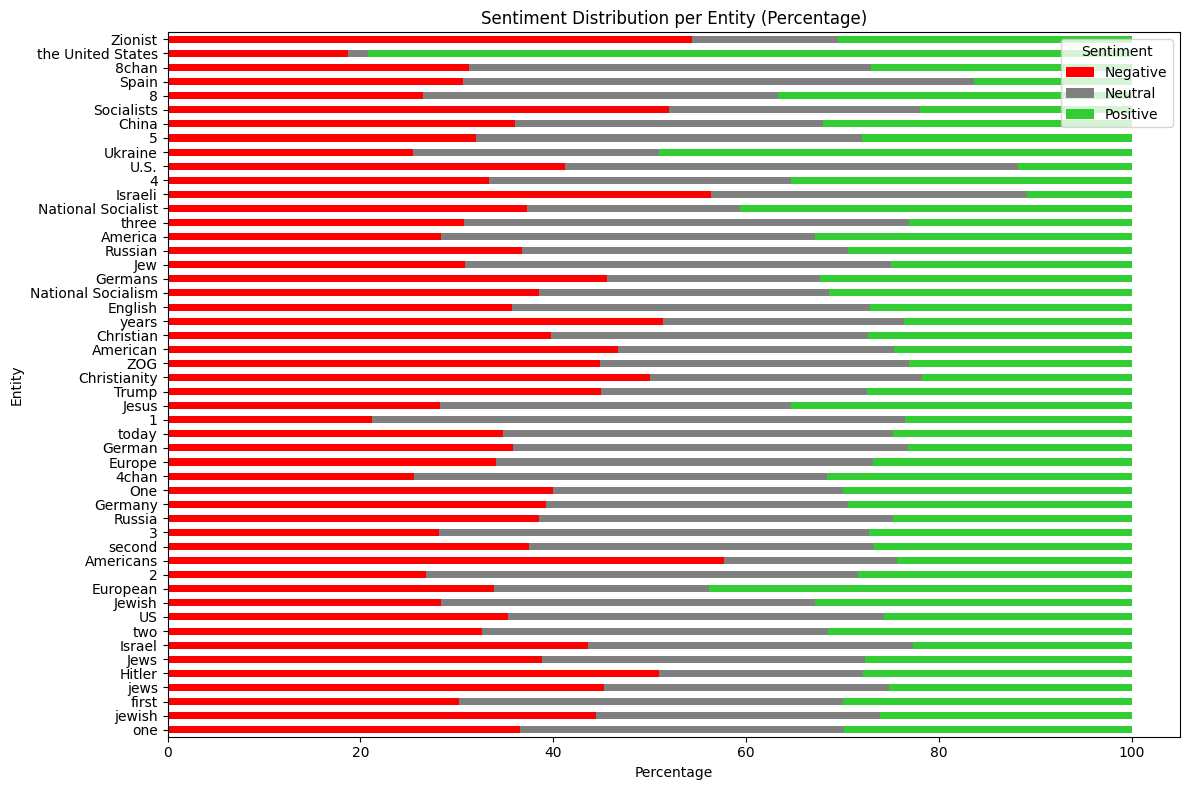

In [82]:
# Flatten entity sentiments into a list of tuples (entity, sentiment)
entity_sentiments = []
for entity_dict in endchan_posts['entity_sentiments'].dropna():
    for entity, sentiment in entity_dict.items():
        # Classify sentiment as negative, neutral, or positive
        sentiment_category = (
            'Negative' if sentiment < -0.05 else
            'Positive' if sentiment > 0.05 else
            'Neutral'
        )
        entity_sentiments.append((entity, sentiment_category))

# Create a DataFrame for entity sentiments
entity_df = pd.DataFrame(entity_sentiments, columns=['Entity', 'Sentiment'])

# Truncate entity names to a maximum length for readability
entity_df['Entity'] = entity_df['Entity'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x)

# Count sentiment categories per entity
sentiment_counts = entity_df.groupby(['Entity', 'Sentiment']).size().unstack(fill_value=0)

# Normalize counts to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Select the top 10 entities with the most sentiment data
top_entities = sentiment_counts.sum(axis=1).nlargest(50).index
top_sentiment_percentages = sentiment_percentages.loc[top_entities]

# Plot the bar chart
top_sentiment_percentages.plot(kind='barh', stacked=True, figsize=(12, 8), color=['red', 'gray', 'limegreen'])
plt.xlabel('Percentage')
plt.ylabel('Entity')
plt.title('Sentiment Distribution per Entity (Percentage)')
plt.legend(title='Sentiment', loc='upper right')
plt.tight_layout()
plt.show()

## 4Chan

In [83]:
# Example usage
chan4_posts['entities'] = chan4_posts['content'].apply(lambda x: extract_entities(x) if isinstance(x, str) else None)
chan4_posts[['content', 'entities']].head()

,content,entities
0,>>501098958 (OP)I used an anal egg to make me ...,[]
1,corporate farming was a mistakepicrel is the c...,"[(one, CARDINAL), (america, GPE)]"
2,>>501098958 (OP)Almost like the old administra...,[]
3,">>501100092Trump started the fake pandemic, st...","[(501100092Trump, CARDINAL)]"
4,>>501098958 (OP)>what did americans mean by th...,"[(americans, NORP)]"


In [84]:
# Apply entity sentiment analysis
chan4_posts['entity_sentiments'] = chan4_posts['content'].apply(lambda x: entity_sentiment(x) if isinstance(x, str) else None)
chan4_posts[['content', 'entity_sentiments']].head()

,content,entity_sentiments
0,>>501098958 (OP)I used an anal egg to make me ...,{}
1,corporate farming was a mistakepicrel is the c...,"{'one': 0.0, 'america': 0.0}"
2,>>501098958 (OP)Almost like the old administra...,{}
3,">>501100092Trump started the fake pandemic, st...",{'501100092Trump': -0.6486}
4,>>501098958 (OP)>what did americans mean by th...,{'americans': -0.6705}


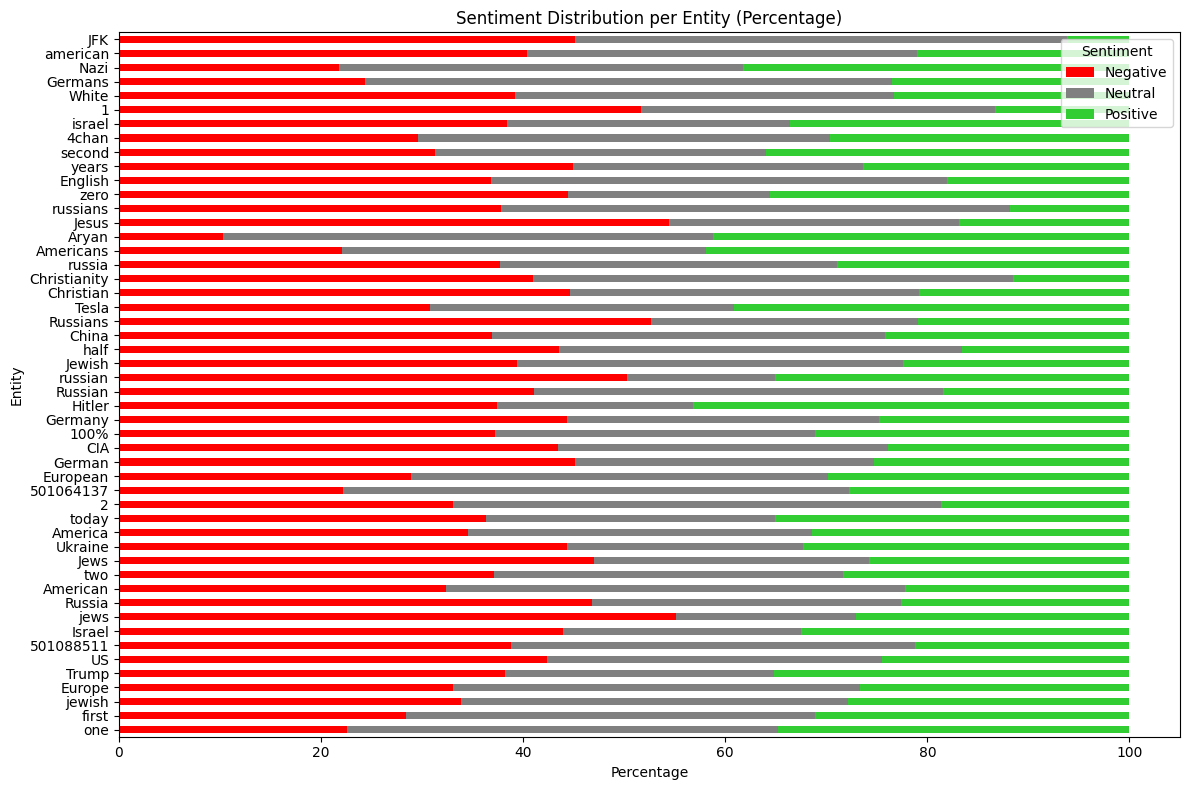

In [85]:
# Flatten entity sentiments into a list of tuples (entity, sentiment)
entity_sentiments = []
for entity_dict in chan4_posts['entity_sentiments'].dropna():
    for entity, sentiment in entity_dict.items():
        # Classify sentiment as negative, neutral, or positive
        sentiment_category = (
            'Negative' if sentiment < -0.05 else
            'Positive' if sentiment > 0.05 else
            'Neutral'
        )
        entity_sentiments.append((entity, sentiment_category))

# Create a DataFrame for entity sentiments
entity_df = pd.DataFrame(entity_sentiments, columns=['Entity', 'Sentiment'])

# Truncate entity names to a maximum length for readability
entity_df['Entity'] = entity_df['Entity'].apply(lambda x: x[:20] + '...' if len(x) > 20 else x)

# Count sentiment categories per entity
sentiment_counts = entity_df.groupby(['Entity', 'Sentiment']).size().unstack(fill_value=0)

# Normalize counts to percentages
sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

# Select the top 10 entities with the most sentiment data
top_entities = sentiment_counts.sum(axis=1).nlargest(50).index
top_sentiment_percentages = sentiment_percentages.loc[top_entities]

# Plot the bar chart
top_sentiment_percentages.plot(kind='barh', stacked=True, figsize=(12, 8), color=['red', 'gray', 'limegreen'])
plt.xlabel('Percentage')
plt.ylabel('Entity')
plt.title('Sentiment Distribution per Entity (Percentage)')
plt.legend(title='Sentiment', loc='upper right')
plt.tight_layout()
plt.show()